# HOMEWORK 4

For this homework you are going to implement a lane line detector. Lane line detection is crucial for ADAS (Advanced Driver Assistance Systems) systems and, in particular, for LKA (Lane Keep Assist). You will use a [picture](https://en.wikipedia.org/wiki/Lane_departure_warning_system) from a front facing camera (mounted on the car) and will implement the following steps:
* Convert image to gray scale
* Compute edge map
* Apply Hough transform to obtain line parametrizations

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load and show the camera frame.

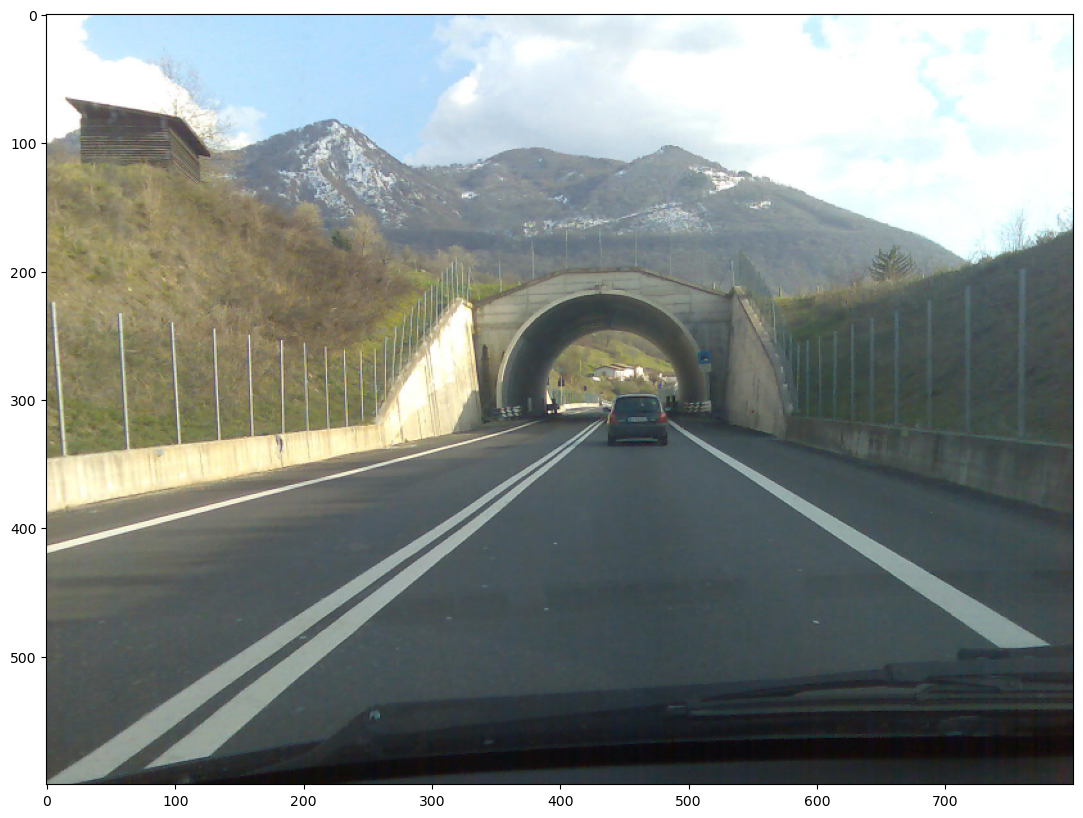

In [2]:
img = cv2.imread('dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)

(<AxesSubplot:title={'center':'Vertical gradient'}>,
 Text(0.5, 1.0, 'Vertical gradient'))

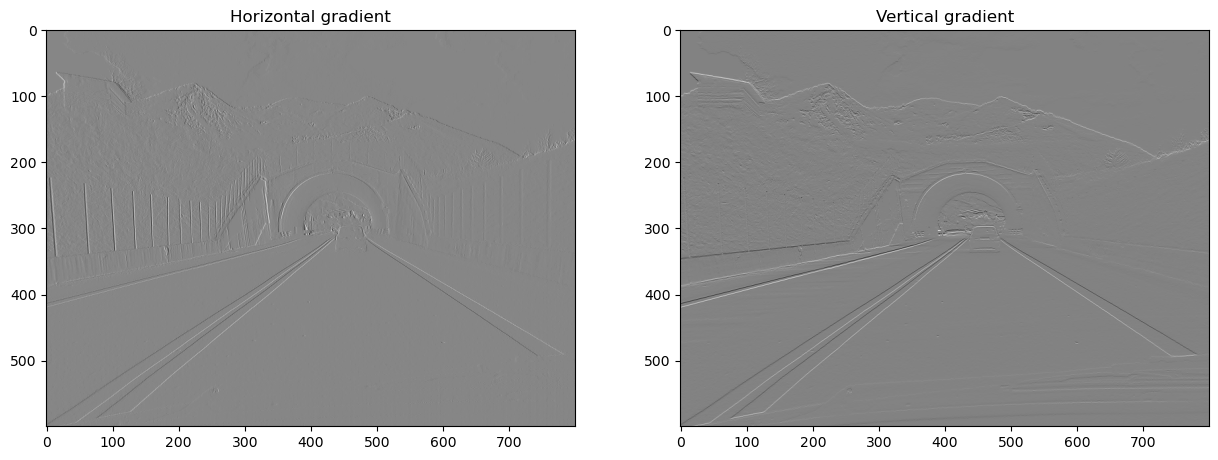

In [3]:
# Convert image to gray scale



# Prepare gray scale image
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = gray/255
#plt.imshow(gray, cmap='gray')

# Set up kernels
kernel_hor = np.array([[1, -1]])
kernel_ver = np.array([[1], [-1]])

# Convolve discrete gradient kernels with the luminance channel
grad_hor = cv2.filter2D(gray, ddepth=-1, kernel=kernel_hor)
grad_ver = cv2.filter2D(gray, ddepth=-1, kernel=kernel_ver)

plt.subplot(121), plt.imshow(grad_hor, cmap='gray'), plt.title('Horizontal gradient')
plt.subplot(122), plt.imshow(grad_ver, cmap='gray'), plt.title('Vertical gradient')

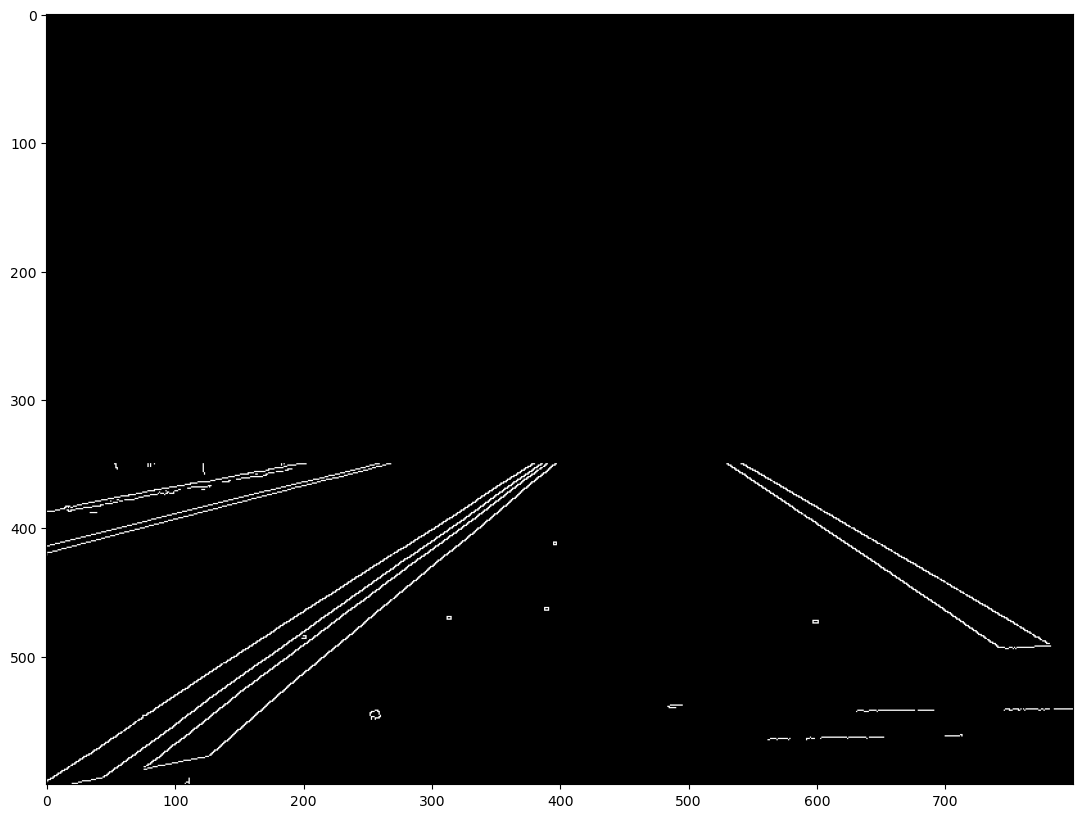

In [4]:
# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
# OpenCV implementation of Canny only accepts uint8 images
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


edges = cv2.Canny(gray, threshold1=100, threshold2=150)

# We are only interseted in the road so we will remove everything above the horizon
edges[0:350] = 0

plt.imshow(edges, cmap='gray')



(<AxesSubplot:title={'center':'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

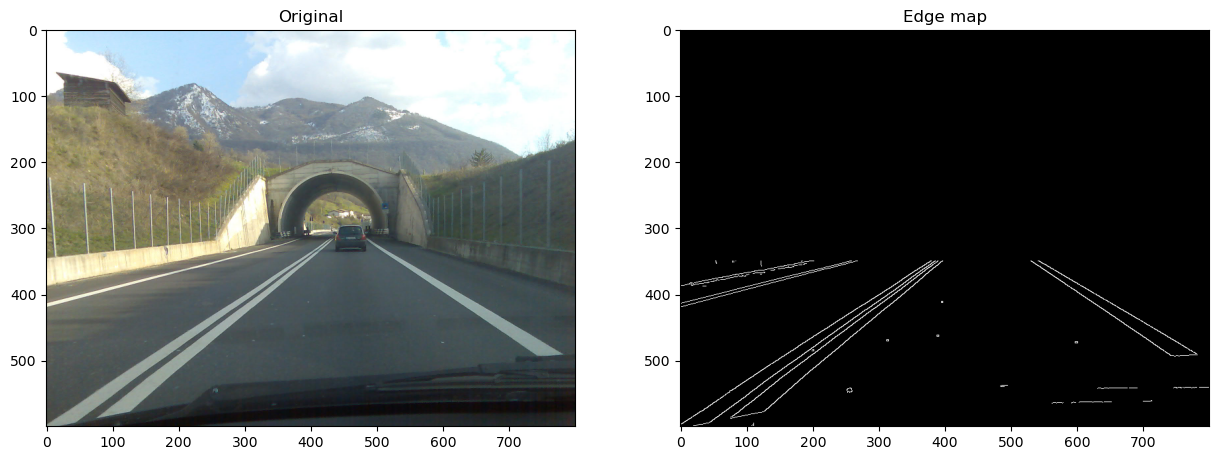

In [5]:
# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

(<AxesSubplot:title={'center':'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

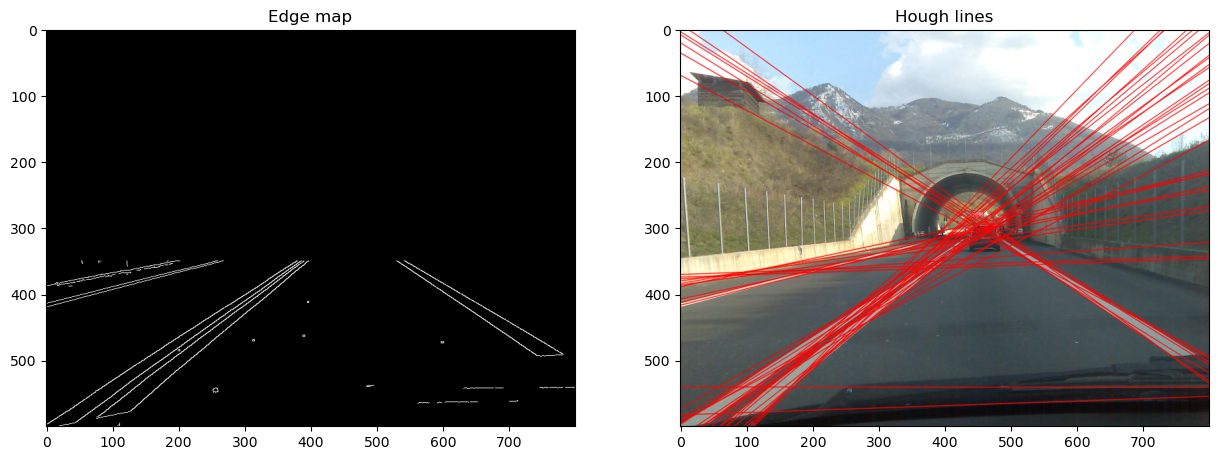

In [6]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190
lines = cv2.HoughLines(edges, rho=2, theta=2*np.pi/180, threshold=80)
hough = np.zeros_like(edges)

# Let's get rid of the unnecessary dimension
lines = lines[:, 0, :]

# Plot the resulting Hough lines
result = np.copy(img);

for line in lines:
#range(0, len(lines[:])):
    #print('Lines:', line);
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The edge map looks good but the Hough lines are too noisy. Let's clean the Hough lines first by removing all lines that we know cannot represent a lane line. In other words, all lines that are approximately horizontal shall be removed. Remember that horizontal lines correspond to theta = 90 degrees.

In [7]:
# Filter out all lines that are approximately horizontal (+/- 20 degrees). 
filtered_lines = []
for line in lines:
    # Extract theta for current line (remember Hough works with radians)
    theta = line[1]
    # Keep line if theta is not horizontal
    celsium =theta * (180/np.pi);
    #print('line degree=', theta * (180/np.pi))
    if (celsium > 110 or celsium < 70 ):
        filtered_lines.append(line);



(<AxesSubplot:title={'center':'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

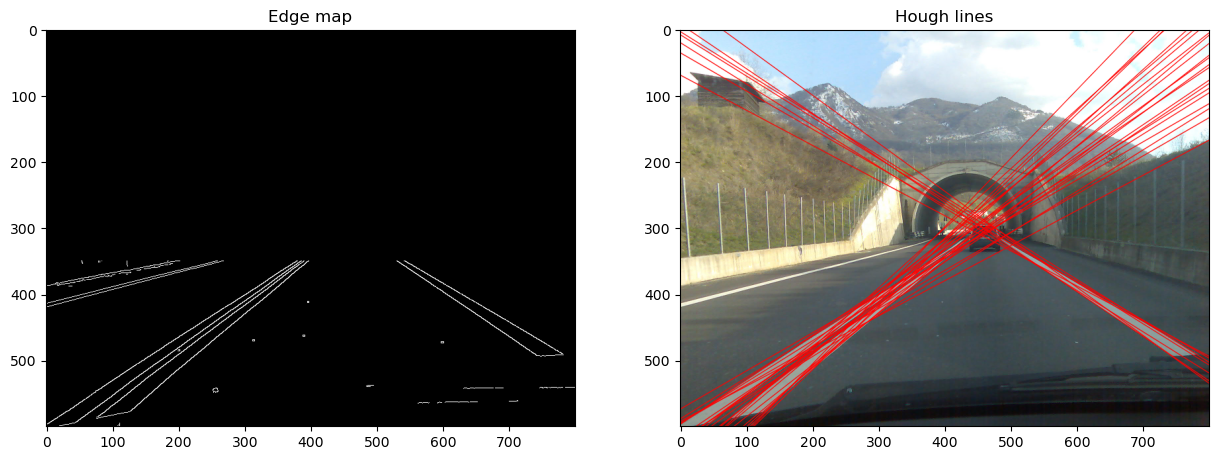

In [8]:
# Let's plot the resulting filtered lines
result = np.copy(img)
 
for line in filtered_lines:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)
    ...

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The result is now much better, but still we see some very similar lines. How can we get rid of them?
* Let's apply k-means clustering. It will find the clusters of the 6 we see in the picture lines and use the averages.

In [9]:
# We will apply k-means clustering to refine the detected lines.
# Don't worry, we will learn about the clustering later in the course :-)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(filtered_lines)
kmeans.cluster_centers_

c:\Users\vlazarenko\Anaconda3\envs\cv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([[517.66666667,   0.96187034],
       [  1.        ,   2.14093725],
       [500.84615385,   0.90488609],
       [ 61.        ,   2.05948853],
       [-37.        ,   2.1991148 ],
       [ 24.        ,   2.11184847]])

(<AxesSubplot:title={'center':'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

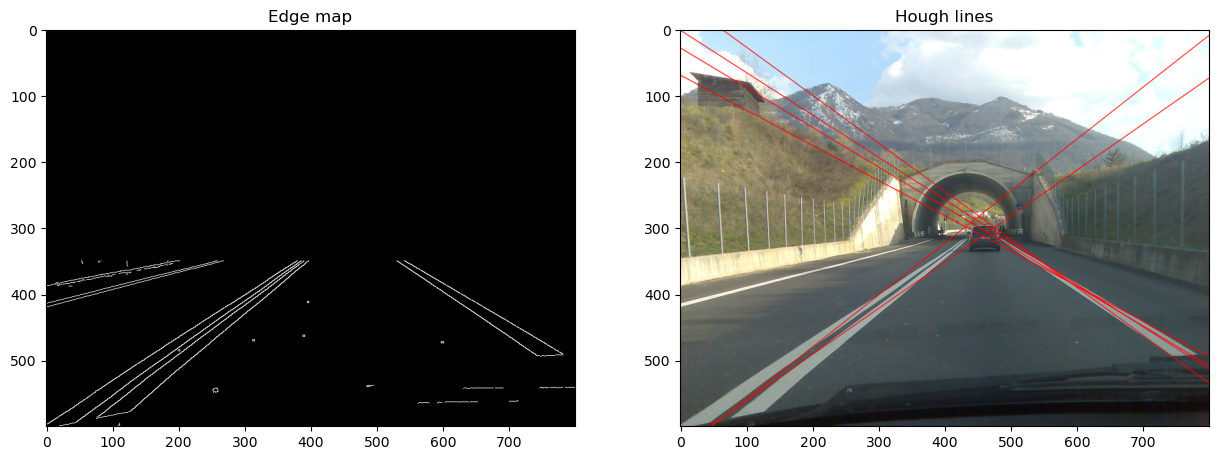

In [10]:
# Again, let's plot the resulting filtered lines
result = np.copy(img)
    
for line in kmeans.cluster_centers_:
    rho = line[0]
    theta = line[1]
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

### Questions
* Do you see anything strange in the final result?

1. Physical line on the road is represented with several lines in the dataset
2. Lines do not stop at the 'horizont' level
3. Algorythms performance is below acceptable level - for me it is doubtful that we can process average video with 25 frames per second. And we did not reach objects recognition yet.

* Do you think the Hough transform resolution is important for obtaining a good result? Why?

4. Resolution is less important for 45, 90 degrees lines and much more important for everything else. The resolution should be optimal to recognize a line under normal light and average recording conditions.

* Do you think the Hough transform accumulator threshold is important for obtaining a good result? Why?

5. We should use appropriate threshold for every recording conditions. With the value below optimal, we will be getting too many lines. And vice versa if the value above optimal.
